# Batch Normalization을 하는 모델과 안하는 모델의 loss비교
### MNIST Data 읽어오기

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

# MNINST 데이터 셋 읽어오기
mnist_train = dsets.MNIST(root="MNIST_data/", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root="MNIST_data/", train=False, transform=transforms.ToTensor(), download=True)

batch_size = 100
# DataLoader생성 (iterator)
data_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

### model, optimizer, loss function 작성

In [2]:
linear1 = torch.nn.Linear(784, 32, bias = True)
linear2 = torch.nn.Linear(32, 32, bias = True)
linear3 = torch.nn.Linear(32, 10, bias = True)

relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias = True)
nn_linear2 = torch.nn.Linear(32, 32, bias = True)
nn_linear3 = torch.nn.Linear(32, 10, bias = True)

# Batch Normalization model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                               linear2, bn2, relu,
                               linear3)
# None Batch Normalization model
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3)

# crossentropy cost사용, pytorch에서는 CrossEntropy가 softmax를 자동으로 계산해줌
criterion = torch.nn.CrossEntropyLoss()
bn_optimizer = torch.optim.SGD(bn_model.parameters(), lr=0.1)
nn_optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.1)

### 학습 진행

In [3]:
epochs = 10
# 그래프로 비교하기위해 모델별 loss값을 저장할 list생성
bn_loss_list = []
nn_loss_list = []
for epoch in range(epochs):
    bn_model.train() #  trainning mode

    for X, Y in data_loader:
        X = X.view(-1, 28 * 28)
        Y = Y
        
        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()
        
        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()    

    with torch.no_grad():
        bn_model.eval() # evaluation mode
        
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for X, Y in data_loader:
            X = X.view(-1, 28 * 28)
            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()
        bn_loss = bn_loss / batch_size
        nn_loss = nn_loss / batch_size
    bn_loss_list.append(bn_loss)
    nn_loss_list.append(nn_loss)

    print(f"epoch : {epochs}/{epoch + 1} : bn_loss : {bn_loss:.4f}, nn_loss : {nn_loss:.4f}")

epoch : 10/1 : bn_loss : 0.9065, nn_loss : 2.0354
epoch : 10/2 : bn_loss : 0.6204, nn_loss : 1.3744
epoch : 10/3 : bn_loss : 0.4712, nn_loss : 1.1604
epoch : 10/4 : bn_loss : 0.4299, nn_loss : 0.9665
epoch : 10/5 : bn_loss : 0.3742, nn_loss : 0.8412
epoch : 10/6 : bn_loss : 0.3256, nn_loss : 0.7445
epoch : 10/7 : bn_loss : 0.3157, nn_loss : 0.7468
epoch : 10/8 : bn_loss : 0.2898, nn_loss : 0.7096
epoch : 10/9 : bn_loss : 0.2593, nn_loss : 0.5801
epoch : 10/10 : bn_loss : 0.2580, nn_loss : 0.4939


### 누적시킨 loss를 비교

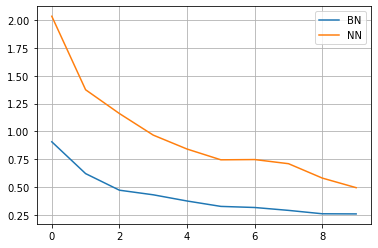

In [4]:
plt.plot(bn_loss_list, label="BN")
plt.plot(nn_loss_list, label="NN")
plt.legend()
plt.grid("on")
plt.show()